In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline

In [2]:
df = pd.read_csv('bms_exp.csv')
df.head()

,id,consistency,difficulty,pain,smell,completeness,urgency,duration,occurred_at,fake_user_id
0,6162,40.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-04 19:10:00,640
1,6161,40.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-04 11:30:00,640
2,6131,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-03 14:05:00,640
3,6103,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-02 22:00:00,640
4,6102,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-02 14:00:00,640


How many users are there? How many BMs has each logged?

In [3]:
number = len(df['fake_user_id'].unique())
print(f'There are {number} users.')
df.groupby('fake_user_id').size().reset_index().rename(columns={0:'# BMs'}).sort_values('# BMs', ascending=False)

There are 19 users.


,fake_user_id,# BMs
18,954,190
10,640,171
6,451,138
8,493,131
15,839,131
11,655,113
7,474,113
3,303,105
9,529,75
12,744,63


What percent of each values is null?

In [4]:
df.isnull().sum() / len(df) * 100

id               0.000000
consistency      0.495356
difficulty      46.687307
pain            68.049536
smell           66.749226
completeness    39.628483
urgency         64.829721
duration         0.000000
occurred_at      0.000000
fake_user_id     0.000000
dtype: float64

For simplicity to begin, let's just drop the features with many null values (`difficulty`, `pain`, `smell`, `completeness`, and `urgency`).

In [5]:
df2 = df.drop(['difficulty', 'pain', 'smell', 'completeness', 'urgency'], axis=1)
df2.head()

,id,consistency,duration,occurred_at,fake_user_id
0,6162,40.0,0,2019-10-04 19:10:00,640
1,6161,40.0,0,2019-10-04 11:30:00,640
2,6131,50.0,0,2019-10-03 14:05:00,640
3,6103,50.0,0,2019-10-02 22:00:00,640
4,6102,50.0,0,2019-10-02 14:00:00,640


In [6]:
df2['duration'].value_counts()

0       1405
5         94
2         33
1         23
3         19
10         7
7          6
9          5
4          5
8          4
11         2
20         2
1443       2
15         1
13         1
12         1
1445       1
6          1
103        1
1440       1
1446       1
Name: duration, dtype: int64

Almost all values of duration are 0, so, to begin, let's drop `duration` too.

In [7]:
df2 = df2.drop('duration', axis=1)
df2.head()

,id,consistency,occurred_at,fake_user_id
0,6162,40.0,2019-10-04 19:10:00,640
1,6161,40.0,2019-10-04 11:30:00,640
2,6131,50.0,2019-10-03 14:05:00,640
3,6103,50.0,2019-10-02 22:00:00,640
4,6102,50.0,2019-10-02 14:00:00,640


Now we need an aggregation of stats per user. Let's start by making a very simple one: average consistency, min consistency, max consistency.

In [8]:
grouped_df = df2.groupby('fake_user_id')

d = {'avg_consistency': grouped_df.mean()['consistency'],
     'min_consistency': grouped_df.min()['consistency'],
     'max_consistency': grouped_df.max()['consistency']}

user_data = pd.DataFrame(data=d)
user_data

,avg_consistency,max_consistency,min_consistency
fake_user_id,,,
148,33.333333,50.0,0.0
161,51.224490,90.0,10.0
277,58.253968,90.0,5.0
303,44.000000,65.0,5.0
341,42.826087,50.0,0.0
355,55.535714,100.0,15.0
451,47.173913,100.0,0.0
474,10.752212,60.0,0.0
493,45.687023,100.0,0.0


Now that we have each user represented as a vector, we can begin clustering.

The first task is to find the optimal number of clusters. I will use the "elbow method" to do this. This method consists of running the clustering algorithm for a range of k values, where k is the number of clusters, calculating an error metric, like sum of squared error, for each, and then finding the value that maximizes the change in slope. For now, I will take the range of clusters to be 1 through (number of users / 2).

In [9]:
def find_optimal_k(df):
    
    X = df
    num_users = df.shape[0]
    scores = []
    possible_ks = range(1, int((num_users / 2) + 1))

    for k in possible_ks:
        kmeans = KMeans(n_clusters=k, random_state=42)   # set a random_state to be sure differences are due to k
        kmeans.fit(X)
        new_score = kmeans.inertia_   # inertia = SSE
        scores.append(new_score)
    
    plt.plot(possible_ks, scores)
    
    changes_in_score = np.diff(scores)
    optimal_k = possible_ks[np.argmin(changes_in_score) + 1]
    
    return optimal_k

The optimal number of clusters is 2.


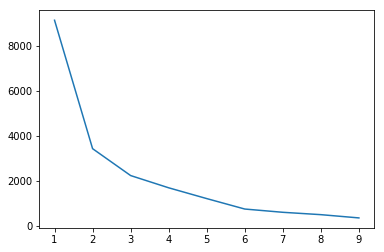

In [10]:
optimal_k = find_optimal_k(user_data)
print(f'The optimal number of clusters is {optimal_k}.')

We can corroborate this value by also using silhouette score as a goodness metric.

In [11]:
def find_optimal_k_using_silhouette(df):
    
    X = df
    num_users = df.shape[0]
    silhouette_scores = []
    possible_ks = range(2, int((num_users / 2) + 1))

    for k in possible_ks:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        new_silhouette_score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(new_silhouette_score)
    
    return possible_ks[np.argmax(silhouette_scores)]

optimal_k_silhouette = find_optimal_k_using_silhouette(user_data)
print(f'The optimal number of clusters using silhouette score is {optimal_k_silhouette}.')

The optimal number of clusters using silhouette score is 2.


Now let's generating a K-Means clustering using that optimal number of clusters.

In [12]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(user_data);

In [13]:
centers = kmeans.cluster_centers_
print(f'The cluster centers are {centers[0]} and {centers[1]}')

The cluster centers are [ 49.8475361   93.75         4.16666667] and [ 35.80238055  60.71428571   5.        ]


In [14]:
user_data['cluster'] = kmeans.labels_
print('The data are clustered as follows: \n')
print(f"There are {user_data[user_data['cluster'] == 0].shape[0]} points in cluster 1.")
display(user_data[user_data['cluster'] == 0])
print(f"There are {user_data[user_data['cluster'] == 1].shape[0]} points in cluster 2.")
display(user_data[user_data['cluster'] == 1])

The data are clustered as follows: 

There are 12 points in cluster 1.


,avg_consistency,max_consistency,min_consistency,cluster
fake_user_id,,,,
161,51.224490,90.0,10.0,0
277,58.253968,90.0,5.0,0
355,55.535714,100.0,15.0,0
451,47.173913,100.0,0.0,0
493,45.687023,100.0,0.0,0
529,45.200000,90.0,0.0,0
744,39.596774,100.0,0.0,0
798,61.285714,100.0,5.0,0
839,48.778626,95.0,0.0,0


There are 7 points in cluster 2.


,avg_consistency,max_consistency,min_consistency,cluster
fake_user_id,,,,
148,33.333333,50.0,0.0,1
303,44.000000,65.0,5.0,1
341,42.826087,50.0,0.0,1
474,10.752212,60.0,0.0,1
640,45.264706,75.0,5.0,1
655,26.061947,65.0,0.0,1
778,48.378378,60.0,25.0,1


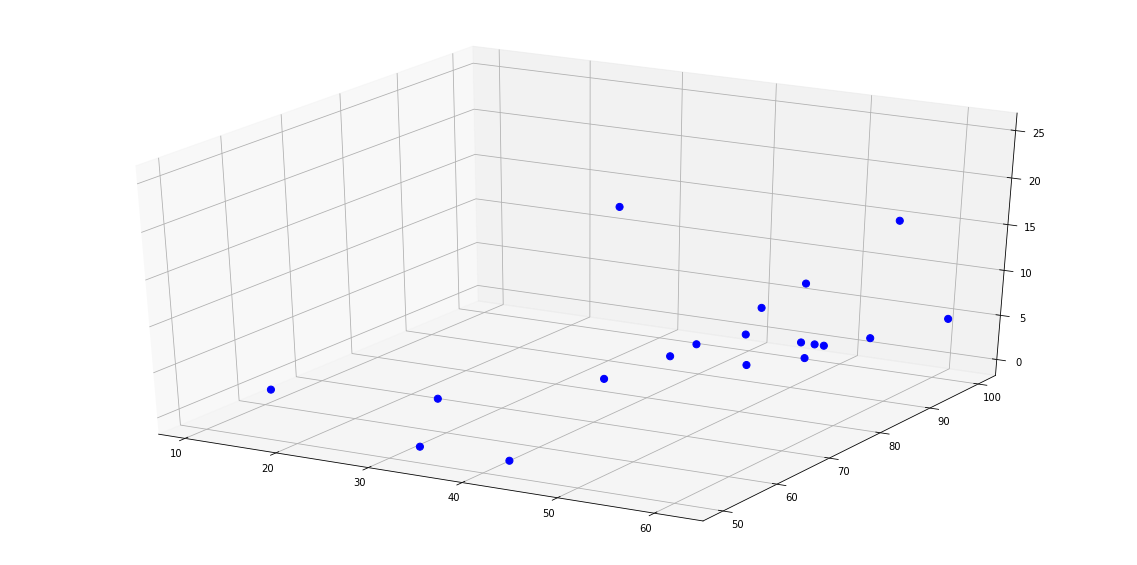

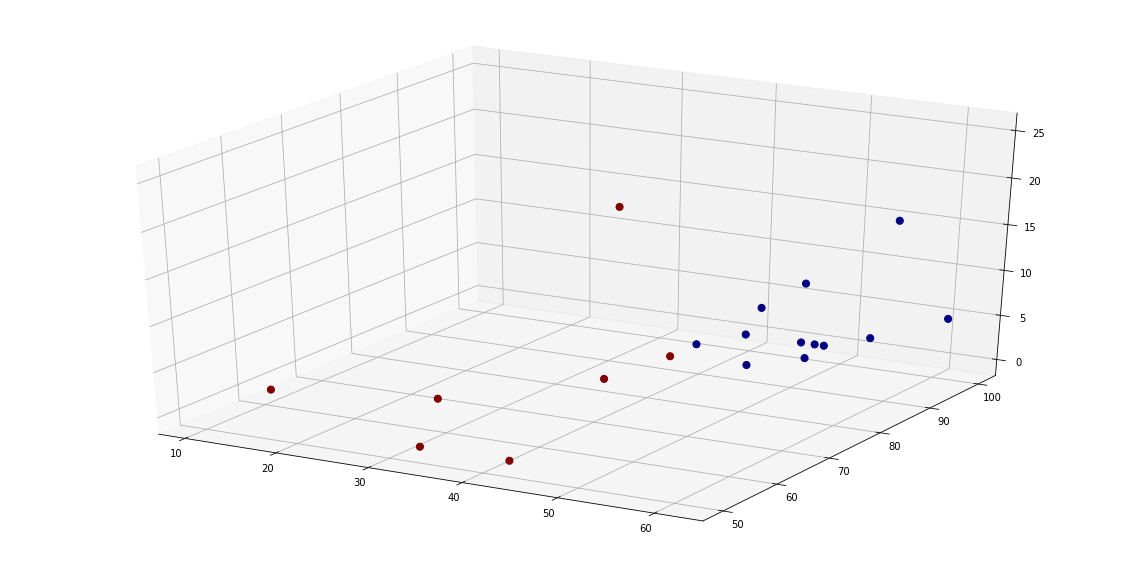

In [15]:
xs = user_data['avg_consistency']
ys = user_data['max_consistency']
zs = user_data['min_consistency']

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, s=50, c='b', alpha=1)

fig2 = plt.figure(figsize=(20, 10))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(xs, ys, zs, s=50, c=user_data['cluster'], cmap='jet', alpha=1)